## Infinite Monkey Theorem

Using genetic algorithm to get to the phrase "To be or not to be that is the question" 

r1: revision to use matrix algebra rather than lists of lists

In [2]:
import numpy as np
import string
import random
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
from itertools import chain

# Create a timer class

In [43]:
class TimerError(Exception):
    """A custom exception used to report errors in use of Timer class"""

class Timer:
    def __init__(self):
        self._start_time = None

    def start(self):
        """Start a new timer"""
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._start_time = time.perf_counter()

    def stop(self,not_quiet=1):
        """Stop the timer, and report the elapsed time"""
        if self._start_time is None:
            raise TimerError(f"Timer is not running. Use .start() to start it")

        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        if not_quiet:
            print(f"Elapsed time: {elapsed_time:0.4f} seconds")
        return elapsed_time

#### Function to Initialize Population

In [45]:
# Generate a random population of random DNA 

# Function to create a random string with n characters
def dna(target):
    n = len(target)
    chars = 'abcdefghijklmnopqrstuvwxyz     ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    element = random.choices(chars,k=n)
    return element

# Function to initialize the population 
def initial_pop(target,popmax):
    population =[]
    population = [dna(target) for i in range(popmax)]
    return population

# Function to initialize the population using matrices
def initial_pop_matrix(target,popmax):
    chars = 'abcdefghijklmnopqrstuvwxyz     ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    population = np.random.choice(list(len(chars)),size=(len(target),popmax))
    return population

In [44]:
times = []
for i in range(100):
    t = Timer()
    t.start()
    p = initial_pop(target,popmax)
    times.append(t.stop(0))
np.mean(times)

0.009673678999998856

In [46]:
times = []
for i in range(100):
    t = Timer()
    t.start()
    p = initial_pop_matrix(target,popmax)
    times.append(t.stop(0))
np.mean(times)

0.00041704999999865323

Improvement of 25x by using a matrix initalization

#### Function to Calculate fitness of each DNA in the population

In [94]:
def calculate_fitness(population, target, popmax):
    fitness_score = [None] * popmax
    b = list(target)
    for idx, val in enumerate(population):
        matches = 0 
        for i, j in zip(val, b):
            if i == j:
                matches+=1 
        fitness_score[idx] = matches/len(b)*100
    
    max_fitness = max(fitness_score)
    max_fitness_index = fitness_score.index(max_fitness)
    return fitness_score, max_fitness_index, max_fitness

def calculate_fitness_matrix(population, target, popmax):
    target_matrix = np.tile(np.array(list(target)).reshape((-1,1)),popmax)
    fitness_score = (population==target_matrix).sum(axis=0)
    max_fitness = max(fitness_score)
    max_fitness_index = np.where(fitness_score == max_fitness)[0]
    return fitness_score, max_fitness_index, max_fitness

In [95]:
times = []
for i in range(100):
    t = Timer()
    p = initial_pop(target,popmax)
    t.start()
    calculate_fitness(p, target, popmax)
    times.append(t.stop(0))
np.mean(times)

0.003815175000004274

In [96]:
times = []
for i in range(100):
    t = Timer()
    p = initial_pop_matrix(target,popmax)
    t.start()
    calculate_fitness_matrix(p, target, popmax)
    times.append(t.stop(0))
np.mean(times)

0.0006514830000060101

Speed improvement of 6x using matrix methods

#### Functions to Create a New Generation
- Generate mating pool
- Crossover
- Mutate 
- Create new generation

In [56]:
#Based on fitness, each member will get added to the mating pool a certain number of times

def mating_pool_function(population,fitness,popmax):
    #Normalize fitness scores against the maximum 
    norm = [float(i)/max(fitness) for i in fitness]
    
    mating_pool = [None] * popmax
    mating_pool = random.choices(population,weights = norm,k=popmax)
    return mating_pool

def mating_pool_function_matrix(population,fitness,popmax):
    #draw random indexes based on fitness score and create new population
    idx = random.choices(list(range(popmax)),weights = fitness,k=popmax)    
    return population[:,idx]

In [57]:
#Crossover to create a new child

def crossover(parent_a,parent_b):
    child = []
    midpoint = random.uniform(0,len(parent_a)) #picking a random midpoint - we do not have a specified crossover rate 
    child = [parent_a[i] if i<midpoint else parent_b[i] for i in range(len(parent_a))]
    return child

def crossover_matrix(parent_a,parent_b):
    #cross over randomly
    randarray = np.random.random(size=parent_a.shape)<.5
    parent_a[randarray] = parent_b[randarray]
    return parent_a

In [58]:
#Mutation: Based on the mutation probability, picks a new random character

def mutate(mutationRate,child):
    chars = 'abcdefghijklmnopqrstuvwxyz     ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    mutate_child = ["".join(random.choices(chars,k=1)) if random.uniform(0,1)<mutationRate else i for i in child]
    return mutate_child

def mutate_matrix(mutationRate,child):
    #fill a random matrix
    rand_char = initial_pop_matrix(target,popmax)
    #determine mutations
    mutator = np.random.random(size=(len(target),popmax))<mutationRate
    #mutate the child where necessary
    child[mutator] = rand_char[mutator]
    return child

In [156]:
#Refill the population with children from the mating pool

def generate(population, fitness, popmax, mutationRate):
    
    #Create mating pool 
    #mating_pool = [None] * popmax
    mating_pool = mating_pool_function(population, fitness, popmax)
    
    new_population = [None] * popmax
    for i in range(popmax):
        a = list(chain(*(random.choices(mating_pool,k=1))))
        b = list(chain(*(random.choices(mating_pool,k=1))))
        child = crossover(a,b)
        mutate_child = mutate(mutationRate,child)
        new_population[i] = mutate_child
    return new_population

def generate_matrix(population, fitness, popmax, mutationRate):
    
    #Create mating pool 
    #mating_pool = [None] * popmax
    #create two parents
    p_a = mating_pool_function_matrix(population, fitness, popmax)
    p_b = mating_pool_function_matrix(population, fitness, popmax)
    crossed = crossover_matrix(p_a,p_b)
    new_pop = mutate_matrix(mutationRate,crossed)
    return new_pop

In [178]:
def get_typing(target, popmax=1000, mutationRate=0.01):
    #runs the simulation to find the time to reach the target
    timer = Timer()


    #Initialize population 
    population = initial_pop_matrix(target,popmax)
    mostFit = []
    generations = 0 
    timer.start()
    max_fitness = 0
    while max_fitness != len(target):
        #Calculate fitness of each member of population and get the most fit member 
        fitness_score, mostFit_index, max_fitness = calculate_fitness_matrix(population, target, popmax)
        #mostFit = "".join(population[mostFit_index])
        #Generate new population 
        population = generate_matrix(population, fitness_score, popmax, mutationRate)
    return timer.stop(0)

#### Run Program

In [180]:
target = "To be or not to be that is the question"
mrate = [0.0001,0.0005,0.001,0.005,0.01]
trials = 10
tdict = {}
for mr in mrate:
    print("Mutation Rate: %0.4f"%(mr))
    a = []
    for i in range(trials):
        t = get_typing(target,1000,mr)
        if (i%5)==0:
            print(i,t)
        a.append(t)
    print("Mutation Rate: %0.4f average time of %0.4fs"%(mr,sum(a)/trials))
    tdict[mr] = sum(a)/trials

Mutation Rate: 0.0001
0 9.116127299999789
5 0.4854932000007466
Mutation Rate: 0.0001 average time of 1.6683s
Mutation Rate: 0.0005
0 0.4979014999998981
5 0.5072537000005468
Mutation Rate: 0.0005 average time of 0.8693s
Mutation Rate: 0.0010
0 0.5749371000001702
5 0.5316229000000021
Mutation Rate: 0.0010 average time of 0.7854s
Mutation Rate: 0.0050
0 0.5690752999998949
5 0.6957398000004105
Mutation Rate: 0.0050 average time of 0.6122s
Mutation Rate: 0.0100
0 4.381050999999388
5 2.4184831000002305
Mutation Rate: 0.0100 average time of 2.8180s


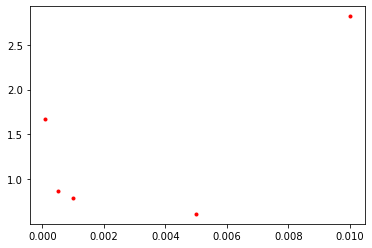

In [181]:
plt.plot(tdict.keys(),tdict.values(),'r.')
plt.show()

In [10]:
target = "unicorn"
popmax = 10
chars = 'abcdefghijklmnopqrstuvwxyz     ABCDEFGHIJKLMNOPQRSTUVWXYZ'
pop = np.random.choice(list(chars),size=(len(target),popmax))
pop

array([['B', 'v', 'N', 't', ' ', 'M', 'e', 'q', ' ', 'C'],
       ['r', 'w', ' ', 'R', 'D', 'P', 'y', 'Q', 'Q', 'T'],
       [' ', 'O', 'P', 'n', 'u', 'B', 'C', 'Y', 'U', 'o'],
       [' ', 'Y', 'y', 'Z', 'B', 'Z', 'D', 'h', 'V', 'Z'],
       ['O', ' ', ' ', 'P', 's', 'S', 'w', 'H', ' ', 'Z'],
       ['P', 'E', 'u', ' ', 'N', 'P', 'R', 'n', 'f', 'T'],
       ['H', ' ', 'H', 'D', 'V', 'l', 'I', 'e', 'z', 'e']], dtype='<U1')

In [19]:
#np.tile(np.array(list(target)).reshape((-1,1)),10)
target_matrix = np.tile(np.array(list(target)).reshape((-1,1)),popmax)

In [23]:
fitness_score = (pop==target_matrix).sum(axis=0)
max_fitness = max(fitness_score)
#max_fitness_index = np.where(fitness_score == max_fitness)[0]
max_fitness

0

In [26]:
np.where(fitness_score == max_fitness)[0]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [28]:
idx = random.choices(list(range(popmax)),weights = fitness_score,k=popmax)

In [30]:
pop[:,idx]

array([['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'],
       ['T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T'],
       ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o'],
       ['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z'],
       ['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z'],
       ['T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T'],
       ['e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e']], dtype='<U1')

In [31]:
def crossover_matrix(parent_a,parent_b):
    #cross over randomly
    randarray = np.random.random(size=parent_a.shape)<.5
    parent_a[randarray] = parent_b[randarray]
    return parent_a

In [34]:
parent_a = pop[0]
parent_b = pop[1]
parent_a, parent_b

(array(['B', 'v', 'N', 't', ' ', 'M', 'e', 'q', ' ', 'C'], dtype='<U1'),
 array(['r', 'w', ' ', 'R', 'D', 'P', 'y', 'Q', 'Q', 'T'], dtype='<U1'))

In [41]:
randarray=np.random.random(size=parent_a.shape)<0.5
randarray

array([False,  True, False,  True, False,  True,  True, False,  True,
       False])

In [42]:
parent_a[randarray] 

array(['v', 't', 'M', 'e', ' '], dtype='<U1')

In [51]:
randarray = np.random.random(size=(len(target),popmax))
np.shape(pop)

(7, 10)

In [61]:
fitness = np.random.random(size = popmax)
p_a = mating_pool_function_matrix(pop, fitness, popmax)
p_a, pop, fitness
#p_b = mating_pool_function_matrix(population, fitness, popmax)
#crossed = crossover_matrix(p_a,p_b)
#new_pop = mutate_matrix(mutationRate,crossed)

(array([['B', ' ', 'B', 'M', ' ', 'M', 'N', 'B', 't', 'B'],
        ['r', 'D', 'r', 'P', 'Q', 'P', ' ', 'r', 'R', 'r'],
        [' ', 'u', ' ', 'B', 'U', 'B', 'P', ' ', 'n', ' '],
        [' ', 'B', ' ', 'Z', 'V', 'Z', 'y', ' ', 'Z', ' '],
        ['O', 's', 'O', 'S', ' ', 'S', ' ', 'O', 'P', 'O'],
        ['P', 'N', 'P', 'P', 'f', 'P', 'u', 'P', ' ', 'P'],
        ['H', 'V', 'H', 'l', 'z', 'l', 'H', 'H', 'D', 'H']], dtype='<U1'),
 array([['B', 'v', 'N', 't', ' ', 'M', 'e', 'q', ' ', 'C'],
        ['r', 'w', ' ', 'R', 'D', 'P', 'y', 'Q', 'Q', 'T'],
        [' ', 'O', 'P', 'n', 'u', 'B', 'C', 'Y', 'U', 'o'],
        [' ', 'Y', 'y', 'Z', 'B', 'Z', 'D', 'h', 'V', 'Z'],
        ['O', ' ', ' ', 'P', 's', 'S', 'w', 'H', ' ', 'Z'],
        ['P', 'E', 'u', ' ', 'N', 'P', 'R', 'n', 'f', 'T'],
        ['H', ' ', 'H', 'D', 'V', 'l', 'I', 'e', 'z', 'e']], dtype='<U1'),
 array([0.79169998, 0.16992179, 0.21977818, 0.52399929, 0.82877063,
        0.94801275, 0.07101551, 0.43370135, 0.35240728, 0.5461

In [64]:
np.random.random(size=p_a.shape)

array([[0.15305717, 0.16999868, 0.07370664, 0.50719659, 0.0467665 ,
        0.37638991, 0.38196925, 0.13718729, 0.97656375, 0.8433901 ],
       [0.96744356, 0.76282942, 0.64334664, 0.16050453, 0.24511529,
        0.66832039, 0.67445095, 0.5753594 , 0.44765774, 0.3873643 ],
       [0.42408169, 0.27024302, 0.26492682, 0.28147972, 0.26385875,
        0.67803289, 0.53966252, 0.74031346, 0.67212153, 0.30870409],
       [0.17347327, 0.43147851, 0.05927271, 0.79892175, 0.42589584,
        0.29833794, 0.16247924, 0.2970894 , 0.73107107, 0.22503948],
       [0.13868061, 0.22263349, 0.32014198, 0.53809086, 0.93629008,
        0.86730847, 0.55363257, 0.77746995, 0.83237086, 0.23654092],
       [0.6498646 , 0.9815168 , 0.09093944, 0.49281024, 0.61896184,
        0.13378465, 0.07570741, 0.21845595, 0.27542452, 0.90881852],
       [0.12472212, 0.03893569, 0.31998162, 0.67598987, 0.44058006,
        0.25356895, 0.10186654, 0.79177606, 0.27746735, 0.13347753]])